#### 실패 : 주제별 토픽모델링 - 주제파악이 어려움

In [1]:
import pandas as pd

In [2]:
import FinanceDataReader as fdr

In [3]:
from tqdm import tqdm

In [4]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [5]:
from sklearn.decomposition import LatentDirichletAllocation

In [6]:
import matplotlib.pyplot as plt

In [7]:
krx_df = fdr.StockListing('KRX')

In [9]:
krx_df.hea

,Code,ISU_CD,Name,Market,Dept,Close,ChangeCode,Changes,ChagesRatio,Open,High,Low,Volume,Amount,Marcap,Stocks,MarketId
0,005930,KR7005930003,삼성전자,KOSPI,,53700,2,-200,-0.37,54100,54700,53500,18625025,1005085420250,320577322935000,5969782550,STK
1,000660,KR7000660001,SK하이닉스,KOSPI,,198200,1,3200,1.64,198000,201000,197700,3620460,721291863250,144290068743000,728002365,STK


In [10]:
krx_df[krx_df['Code'] == '5930']

,Code,ISU_CD,Name,Market,Dept,Close,ChangeCode,Changes,ChagesRatio,Open,High,Low,Volume,Amount,Marcap,Stocks,MarketId


In [8]:
community_contents = pd.read_csv('community_add_poslabel.csv')

In [9]:
community_contents.head()

,닉네임,날짜,내용,종목,내용_토큰,label
0,GROK,2025-01-11T22:59:18+09:00,- 디자인 변화: S25 울트라는 기존의 각진 디자인에서 둥근 모서리로 변경되었으며...,005930,디자인 변화 울트라 기존 디자인 에서 둥글다 모서리 변경 되어다 카메라 모듈 디자인...,1
1,공감아,2025-01-11T22:47:22+09:00,7만원 8만원에 물려있는게 대부분이라 7만원까지 혹여 올라도 물려있던분들은 원금 회...,005930,만원 만원 물리다 대부분 이라 만원 까지 오르다 물리다 분들 원금 회복 다시 매도 ...,-2
2,곰돌이와콩이,2025-01-11T22:41:04+09:00,분할매수하기에 좋은 타점이지만.. 얘는 너무느리고 오래걸린다 얘를살바에 살게 너무많...,005930,분할 매다 좋다 타점 이지만 너무 느리다 오래 걸리다 살바 너무 많다 단점,1
3,김브래,2025-01-11T21:31:55+09:00,존버하면 오르겠죠?,005930,존버하 오르다,-2
4,김보리씨,2025-01-11T21:07:54+09:00,오를 겁니다. 제가 오늘 열심히 일하고 퇴근했습니다.,005930,오르다 겁니다 오늘 열심히 하고 퇴근 하다,1


In [15]:
# 종목코드 자릿수손실 : 6자리 채우기
community_contents['종목'] = community_contents['종목'].apply(
    lambda x: f"{x.zfill(6)}" if len(x) < 6 else x
)

In [10]:
# community_contents와 krx_df를 '종목'과 'Code'를 기준으로 병합합니다.
community_contents = community_contents.merge(
    krx_df[['Code', 'Market']],
    left_on='종목',
    right_on='Code',
    how='left'
)

# '시장' 열 이름을 변경합니다.
community_contents.rename(columns={'Market': '시장'}, inplace=True)

In [11]:
community_contents.drop(columns=['Code'], inplace=True)

In [12]:
community_contents.head()

,닉네임,날짜,내용,종목,내용_토큰,label,시장
0,GROK,2025-01-11T22:59:18+09:00,- 디자인 변화: S25 울트라는 기존의 각진 디자인에서 둥근 모서리로 변경되었으며...,005930,디자인 변화 울트라 기존 디자인 에서 둥글다 모서리 변경 되어다 카메라 모듈 디자인...,1,KOSPI
1,공감아,2025-01-11T22:47:22+09:00,7만원 8만원에 물려있는게 대부분이라 7만원까지 혹여 올라도 물려있던분들은 원금 회...,005930,만원 만원 물리다 대부분 이라 만원 까지 오르다 물리다 분들 원금 회복 다시 매도 ...,-2,KOSPI
2,곰돌이와콩이,2025-01-11T22:41:04+09:00,분할매수하기에 좋은 타점이지만.. 얘는 너무느리고 오래걸린다 얘를살바에 살게 너무많...,005930,분할 매다 좋다 타점 이지만 너무 느리다 오래 걸리다 살바 너무 많다 단점,1,KOSPI
3,김브래,2025-01-11T21:31:55+09:00,존버하면 오르겠죠?,005930,존버하 오르다,-2,KOSPI
4,김보리씨,2025-01-11T21:07:54+09:00,오를 겁니다. 제가 오늘 열심히 일하고 퇴근했습니다.,005930,오르다 겁니다 오늘 열심히 하고 퇴근 하다,1,KOSPI


In [16]:
community_contents.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77647 entries, 0 to 77646
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   닉네임     77647 non-null  object
 1   날짜      77647 non-null  object
 2   내용      77647 non-null  object
 3   종목      77647 non-null  object
 4   내용_토큰   77647 non-null  object
 5   label   77647 non-null  int64 
 6   시장      77647 non-null  object
dtypes: int64(1), object(6)
memory usage: 4.1+ MB


In [14]:
# NaN 값을 'ETF'로 채우기
community_contents['시장'] = community_contents['시장'].fillna('ETF')

In [15]:
community_contents.to_csv('community_add_market2.csv', index=False, encoding='utf-8-sig')

In [26]:
# 토픽 모델링
# 'KOSPI', 'KOSDAQ', 'ETF' 유형별 1000개 샘플링
sample_1 = community_contents[community_contents['시장'] == 'KOSPI'].sample(n=1000, random_state=2025)
sample_2 = community_contents[community_contents['시장'] == 'KOSDAQ'].sample(n=1000, random_state=2025)
sample_3 = community_contents[community_contents['시장'] == 'ETF'].sample(n=1000, random_state=2025)

In [28]:
# 샘플 통합
total_sample = pd.concat([sample_1,sample_2,sample_3], ignore_index=True)

In [ ]:
total_sample['부사_어간'].head(20)

In [38]:
# 문자열 정리를 위한 함수 정의
def clean_verbs(verb_string):
    if isinstance(verb_string, str):  # 문자열인지 확인
        return verb_string.replace(", ,,", ",").replace(", ", ",").strip(", ")
    return verb_string  # 문자열이 아닐 경우 원래 값을 반환

In [43]:
# '동사_어간' 열에 함수 적용
total_sample['부사_어간'] = total_sample['부사_어간'].apply(clean_verbs)

In [56]:
total_sample.head(2)

,닉네임,날짜,내용,종목,내용_명사,내용_형용사,내용_부사,내용_동사,내용_명사_str,내용_형용사_str,내용_부사_str,내용_동사_str,형용사_어간,부사_어간,동사_어간,긍정점수,시장
0,1분내인내심,2024-12-16T11:50:08+09:00,또 사줄께 내려와ㅋㅋㅋ,000660,['또'],[],[],"['사줄께', '내려와']",또,NaN,NaN,"사줄께, 내려와",NaN,NaN,"사주다,내려오다",-1,KOSPI
1,전자공학개이,2025-01-08T09:51:18+09:00,상한가 “해줘”,003490,['상한'],[],[],['해줘'],상한,NaN,NaN,해줘,NaN,NaN,해주다,0,KOSPI


In [59]:
tqdm.pandas()

In [60]:
total_sample['내용2'] = total_sample[['내용_명사_str','형용사_어간','부사_어간','동사_어간']].fillna('').progress_apply(lambda x : ' '.join(x), axis=1)

100%|██████████| 3000/3000 [00:00<00:00, 177194.16it/s]


In [ ]:
total_sample.head()

In [63]:
cvect = CountVectorizer(max_features=4000)
tvect = TfidfVectorizer(max_features=4000)

In [64]:
x_cvect = cvect.fit(total_sample['내용2'])
x_tvect = tvect.fit(total_sample['내용2'])

In [65]:
x_cvect_dim = x_cvect.transform(total_sample['내용2'])
x_tvect_dim = x_tvect.transform(total_sample['내용2'])

In [66]:
x_cvect_dim, x_tvect_dim

(<3000x4000 sparse matrix of type '<class 'numpy.int64'>'
 	with 17588 stored elements in Compressed Sparse Row format>,
 <3000x4000 sparse matrix of type '<class 'numpy.float64'>'
 	with 17588 stored elements in Compressed Sparse Row format>)

In [67]:
df_x_cvect_dim = pd.DataFrame(x_cvect_dim.toarray(), columns=x_cvect.get_feature_names_out())
display(df_x_cvect_dim.head(2))
df_x_tvect_dim = pd.DataFrame(x_tvect_dim.toarray(), columns=x_tvect.get_feature_names_out())
display(df_x_tvect_dim.head(2))

,가가,가격,가결,가계,가구,가그라,가기,가까워지다,가까이,가깝다,...,히힛,힌국,힘내다,힘내핑,힘드다,힘들다,힘스,힘좀,힘주다,힘차다
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


,가가,가격,가결,가계,가구,가그라,가기,가까워지다,가까이,가깝다,...,히힛,힌국,힘내다,힘내핑,힘드다,힘들다,힘스,힘좀,힘주다,힘차다
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [69]:
# 토픽수
n_components = 3
LDA_model = LatentDirichletAllocation(n_components = n_components, random_state=2025)

In [74]:
W = LDA_model.fit(x_cvect_dim).transform(x_cvect_dim)

In [75]:
# 토픽과 연관된 단어
H = LDA_model.components_

# 토픽별 분포도 확인
H

array([[ 1.33276002, 10.01828567,  0.36309071, ...,  3.33162286,
         0.33415702,  2.3427271 ],
       [ 0.33413075, 25.20803142,  1.32253938, ...,  0.33425617,
         0.33427457,  0.33390879],
       [ 1.33310923,  1.77368291,  1.31436992, ...,  0.33412097,
         2.33156842,  1.32336411]])

In [98]:
stop_words = ['하다','되다', '보다','이다','있다',
              '가다','오다','추다','오늘','어제',
              '아니다','계좌','않다','들다','주식',
              '들다', '주다','없다','이제','다시',
              '많이','받다','같다','진짜','줍다',
              '생각','좋다','지금'
              ]

In [99]:
# CountVectorizer에 불용어 추가
cvect = CountVectorizer(max_features=4000, stop_words=stop_words)

In [100]:
# 벡터화
x_cvect_dim = cvect.fit_transform(total_sample['내용2'])

In [101]:
# LDA 모델 재학습
# LDA 모델 설정
n_components = 3
LDA_model = LatentDirichletAllocation(n_components=n_components, random_state=2025)

In [102]:
# LDA 모델 학습
W = LDA_model.fit(x_cvect_dim).transform(x_cvect_dim)

In [103]:
# 토픽과 연관된 단어
H = LDA_model.components_

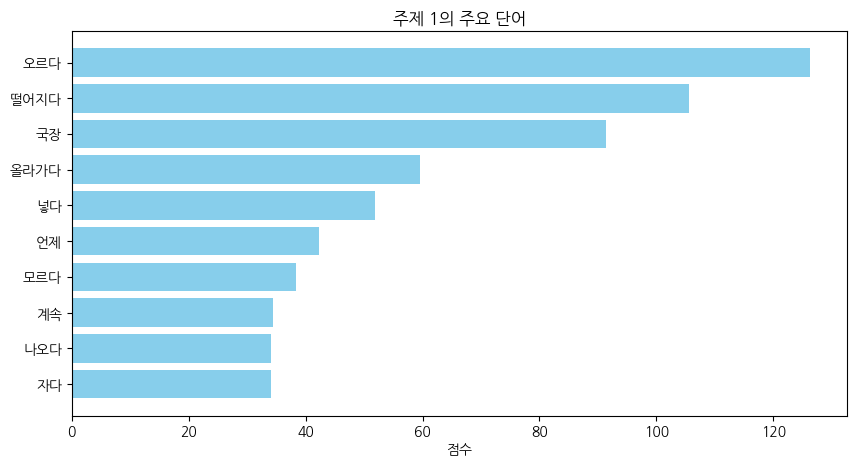

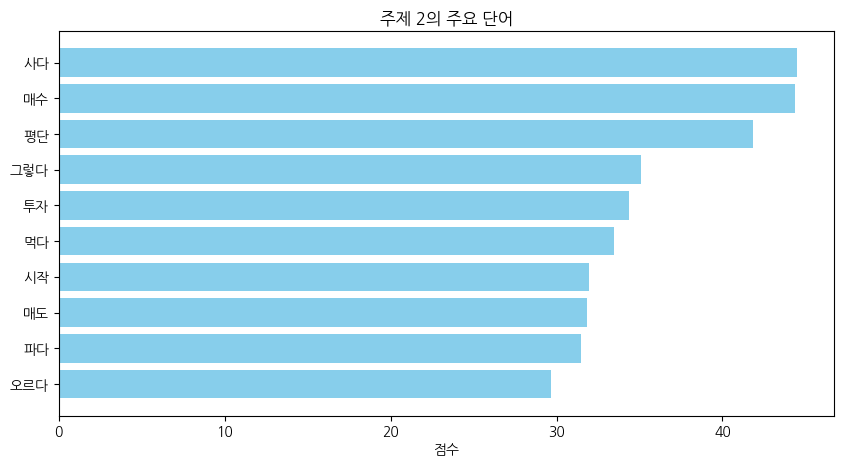

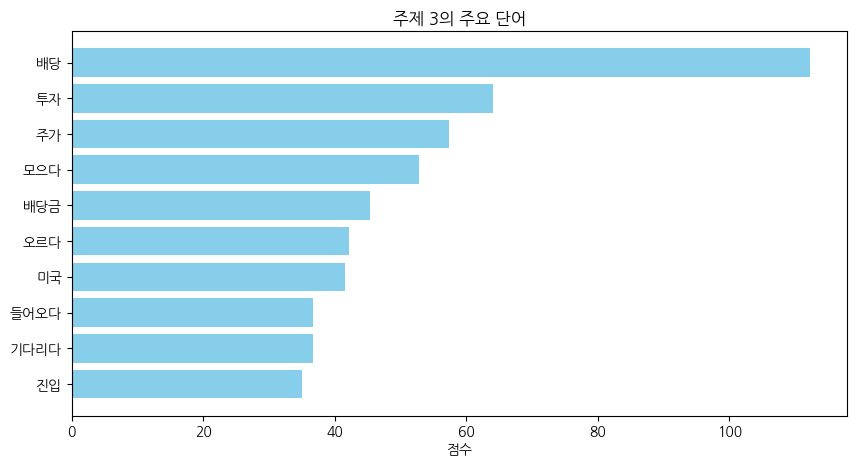

In [104]:

n_words = 10  # 각 주제에서 표시할 단어 수
# 각 주제별 주요 단어를 시각화
for topic_idx in range(n_components):
    plt.figure(figsize=(10, 5))
    
    # 주제의 단어 점수 가져오기
    topic_word = H[topic_idx]
    
    # 상위 n_words 개의 단어 인덱스 가져오기
    top_word_indices = topic_word.argsort()[-n_words:][::-1]
    
    # 주요 단어와 해당 점수 가져오기
    top_words = [cvect.get_feature_names_out()[i] for i in top_word_indices]
    top_word_scores = topic_word[top_word_indices]
    
    # 바 차트 그리기
    plt.barh(top_words, top_word_scores, color='skyblue')
    plt.xlabel('점수')
    plt.title(f'주제 {topic_idx + 1}의 주요 단어')
    plt.gca().invert_yaxis()  # 상단에서 하단으로 표시
    plt.show()

In [ ]:
n = len(df_lda_H_cvect)